In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import time
import sys
import random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class InitialBlock(nn.Module):
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

In [0]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag

        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            extras = extras.to(device)
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [0]:
class UBNeck(nn.Module):
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # Concat
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class SAD(nn.Module):
  def __init__(self):
    super().__init__()
    self.bilinear_upsample = nn.Upsample(size = (256,512), mode='bilinear')
    self.spatial_softmax = torch.nn.Softmax2d()

  def forward(self, x):
    x = self.bilinear_upsample(x)
    x = self.spatial_softmax(x)
    x = torch.sum(x, dim = 1)
    return x

In [0]:
class ENet(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        self.at_gen1 = SAD()
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.at_gen2 = SAD()
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.at_gen3 = SAD()
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.at_gen4 = SAD()
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x, with_SAD = False):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        # print('A1', x.size())
        if(with_SAD):
          #first attention map
          A1 = self.at_gen1(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        # print('A2', x.size())
        if(with_SAD):
          #Second attention map
          A2 = self.at_gen2(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        # print('A3', x.size())
        if(with_SAD):
          #third attention map
          A3 = self.at_gen3(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        # print('A4', x.size())
        if(with_SAD):
          #forth attention map
          A4 = self.at_gen4(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        if(not with_SAD):
          return x

        else:
          return x, A1, A2, A3, A4

In [0]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256,512)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_train_label = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

transform_test = transforms.Compose([
    # transforms.Resize((128,128)),  
    # transforms.Resize((375,1242)),                                   
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [0]:
class Dataset(data.Dataset):
#   'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels, setname):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.setname = setname

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        # X = torch.load('data/' + ID + '.pt')
        X = Image.open(ID)
        X = X.crop((0,0,0,20))
        X = transform_train(X)
        
        y = Image.open(self.labels[ID])
        y = y.crop((0,0,0,20))
        y = transform_train_label(y)

        return X, y


class MyDataset(data.Dataset):
    def __init__(self, list_IDs, labels, train=True):
        
        self.labels = labels
        self.list_IDs = list_IDs
        self.train = train

    def transform(self, image, mask):
    
        # Resize
        resize = transforms.Resize(size=(256, 512))
        image = resize(image)
        mask = resize(mask)
        # depth = resize(depth)

        # Random horizontal flipping
        if random.random() > 0.5 and train:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        # Transform to tensor
        t = transforms.ToTensor()
        image = t(image)
        mask = t(mask)
        # depth = t(depth)

        # Normalise
        normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        normalize1 = transforms.Normalize([0.491], [0.2023])
        image = normalize(image)
        # depth = normalize1(depth)

        # image = torch.cat((image, depth), 0)
    
        return image, mask

    def __getitem__(self, index):
        ID = self.list_IDs[index]
        # new_path = '/content/drive/My Drive/depth_city/'
        image = Image.open(ID)
        mask = Image.open(self.labels[ID])
        # depth = Image.open(new_path + ID[33:])
        # ColorJitter
        color = transforms.ColorJitter(brightness=.05, contrast=.05, hue=.05, saturation=.05)
        if train:
            image = color(image)
        w, h = image.size
        image = image.crop((0, 0, w, h-20))
        mask = mask.crop((0, 0, w, h-20))
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.list_IDs)

In [0]:
path = '/content/drive/My Drive/New_City/'
files_img = ['cityscapes/', 'gtFine/']

In [0]:
partition = {}
labels = {}

for f in os.listdir(path + files_img[0]):
    partition[f] = []
    
    for city in os.listdir(path + files_img[0] + f):
        for image_name in os.listdir(path + files_img[0] + f + '/' + city):
            key = path + files_img[0] + f + '/' + city + '/' + image_name
            value = path + files_img[1] + f + '/' + city + '/' + image_name[:-16] + '_gtFine_color.png'
            if image_name != '.ipynb_checkpoints':
                partition[f].append(key)
                labels[key] = value

In [0]:
def loader(partition, labels, setname):

    params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 12}

    train = MyDataset(partition[setname], labels, False)
    train_loader = data.DataLoader(train, **params)

    return train_loader

In [0]:
#### Loading data

train_loader = loader(partition, labels, 'train')
# val_loader = loader(partition, labels, 'val')
# test_loader = loader(partition, labels, 'test')


In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint
    
    for parameter in model.parameters():
        parameter.requires_grad = True

    m = model.eval()
    return model

In [0]:
def calculate_accuracy(net, prob, img_dir_test, img_dir_test_label):
    SMOOTH = 0
    correct = 0.0
    total = 0.0

    for f in os.listdir(img_dir_test):
        print(f)
        for name in os.listdir(img_dir_test + f):
            try:
                start = time.time()  #### Measuring time (start)

                mask, masked_image = test(img_test_dir=img_dir_test + f + '/' + name, prob=0.85)

                time_taken = time.time() - start  #### Measuring time (diff)

                print('Time taken to execute ==>', time_taken)
                
                label = cv2.resize(cv2.imread(img_dir_test_label + f + '/' + name[:-16] + '_gtFine_color.png', 0), (mask.shape[1], mask.shape[0]))

                total += label.shape[0] * label.shape[1]

                for i in range(len(label)):
                    for j in range(len(label[0])):
                        if label[i,j] == mask[i,j]:
                            correct += 1.0

                SMOOTH += 1
                if SMOOTH == 100:
                    break
            
            except:
                pass
            if SMOOTH == 100:
                break

    return correct / total



In [0]:
from google.colab.patches import cv2_imshow

In [0]:
PATH = '/content/drive/My Drive/Models/ENet.pt'

In [0]:
def train(net, train_loader, num_epoch, lr, PATH=PATH, with_graph=False, save_=False):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    
    for epoch in range(146, num_epoch+150):

        running_loss = 0.0
      
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, label = data

            # outputs = net(inputs)

            try:
                inputs = inputs.to(device)
                label = label.to(device)


                optimizer.zero_grad()
                outputs = net(inputs)
                # outputs = net(inputs)
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print('| WARNING: ran out of memory, retrying batch',sys.stdout)
                    sys.stdout.flush()
                    for p in net.parameters():
                        if p.grad is not None:
                            del p.grad  # free some memory
                    torch.cuda.empty_cache()
                    inputs = inputs.to(device)
                    label = label.to(device)

                    optimizer.zero_grad()
                    outputs = net(inputs)
                else:
                    raise e

            loss1 = criterion(outputs, label.squeeze().long())
            loss2 = 0
            outputs = outputs.data.cpu().numpy()
            for d in range(outputs.shape[0]):
                pred = outputs[d][0]
                pred = np.argmax(pred, axis=0)
                pred = pred.astype(np.uint8)
                pred = pred*255.
                lbl = label.data[d].cpu().numpy()[0]
                intersection = ((pred==255.) & (lbl*255.==255.)).sum()
                union = ((pred==255.) | (lbl*255.==255.)).sum()
                if union == 0:
                    continue
                loss2 += (1-(intersection/union))
            loss2 /=32
            loss3 = nn.MSELoss(A1, A2) + nn.MSELoss(A2, A3) + nn.MSELoss(A3, A4)
            loss = loss1 + alpha*loss2 + beta*loss3
            loss_1+= loss1.item()
            loss_2+= alpha*loss2.item()
            loss_3+= beta*loss3.item()
            # print(loss.item(), loss1.item(), loss2.item(), alpha*loss3.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # print(running_loss)
        
        running_loss /= len(train_loader)
        loss_1 /= len(train_loader)
        loss_2 /= len(train_loader)
        loss_3 /= len(train_loader)
        print('running loss => ', running_loss, 'loss_1', loss_1, 'loss_2', loss_2, 'loss_3', loss_3)
        j+=1
        if with_graph:
            j_list.append(j)
            loss_list.append(running_loss)
            plt.plot(j_list, loss_list)
            plt.pause(0.00001)

        if save_ and epoch%5==0:
            torch.save(net, '/content/drive/My Drive/Models/ENet_SAD'+str(epoch+50)+'.pt')
            # print('test accuracy ==> ' ,calculate_accuracy(net, 0.79, img_dir_test, img_dir_test_label))

    #     print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
    torch.save(net, PATH)
    return net

In [0]:
net = ENet(C=2)
# net.load_state_dict(torch.load('/content/drive/My Drive/Models/ENet45.pt'))
net = torch.load('/content/drive/My Drive/Models/ENet45.pt')
# model.to(device)
net = net.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


running loss =>  0.06429260099927585 loss_1 0.038750162668606286 loss_2 0.009903242772547342 loss_3 0.01563919539650537


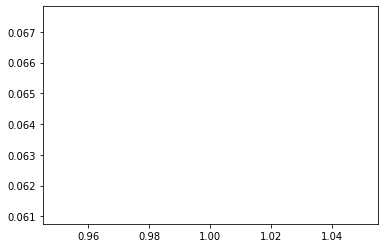

running loss =>  0.06444917607211298 loss_1 0.03887548924533911 loss_2 0.009908599505325626 loss_3 0.015665086794354837


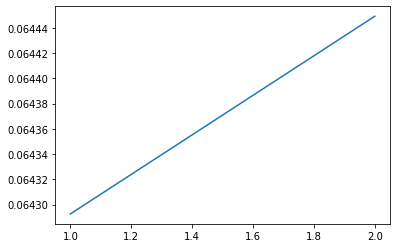

running loss =>  0.06397428075152059 loss_1 0.038424120775313785 loss_2 0.009901006950272588 loss_3 0.015649152906586025


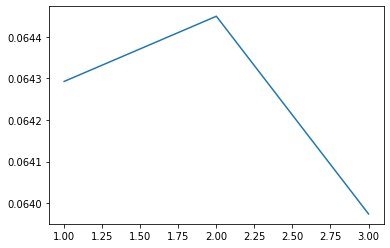

running loss =>  0.06404041823360228 loss_1 0.03847800121111895 loss_2 0.00990116139937435 loss_3 0.01566125569556451


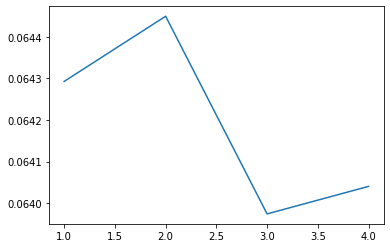

running loss =>  0.06448372173052962 loss_1 0.03892854318743752 loss_2 0.009901127840741986 loss_3 0.015654050235215048


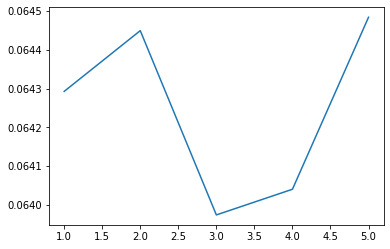

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ENet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type InitialBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/

running loss =>  0.06410749424849788 loss_1 0.038551621038907316 loss_2 0.009913915102343336 loss_3 0.01564195766129032


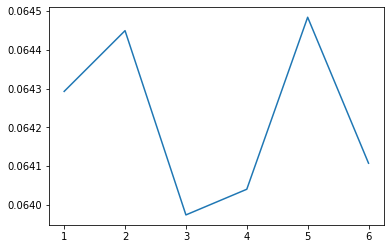

running loss =>  0.06444413571428227 loss_1 0.038883506650886225 loss_2 0.009913239369230173 loss_3 0.01564738985215054


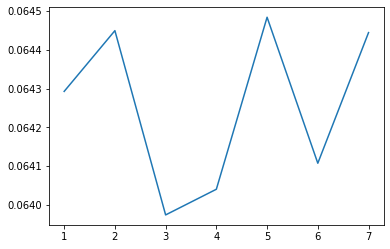

running loss =>  0.06412584066230764 loss_1 0.038580253219572445 loss_2 0.00990091007975904 loss_3 0.01564467728494623


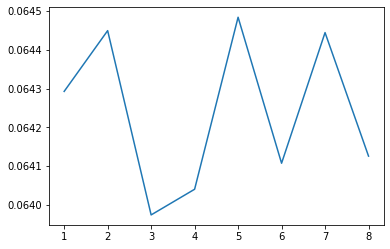

running loss =>  0.06394977246721585 loss_1 0.038398019308524746 loss_2 0.00990739451652548 loss_3 0.015644358350134405


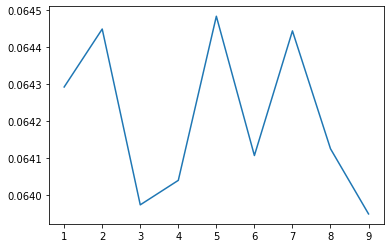

running loss =>  0.06452774745161816 loss_1 0.03898336297722273 loss_2 0.009909353458484961 loss_3 0.01563503086357527


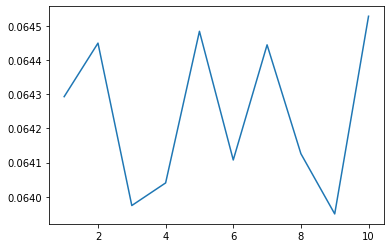

running loss =>  0.0640640363738101 loss_1 0.03853603690782542 loss_2 0.009887648601664351 loss_3 0.01564035095766129


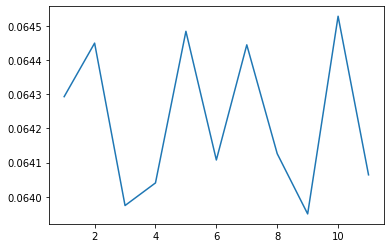

running loss =>  0.06380084064859216 loss_1 0.038276360600545845 loss_2 0.00989450343962581 loss_3 0.015629976864919348


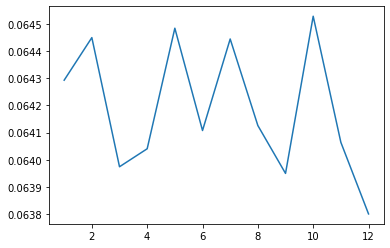

running loss =>  0.06439627558794073 loss_1 0.03884978324014653 loss_2 0.009920636426420212 loss_3 0.015625855796370974


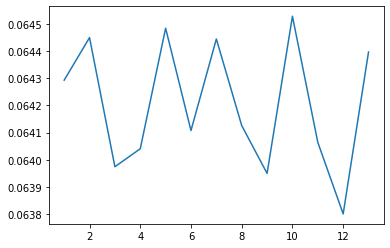

running loss =>  0.06421418880583138 loss_1 0.03865441027027305 loss_2 0.009924726466715682 loss_3 0.015635051780913983


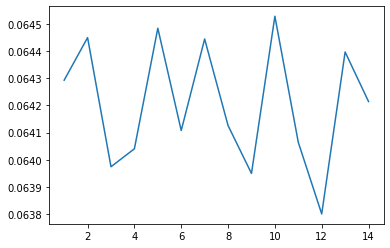

running loss =>  0.06415977989954333 loss_1 0.038627080298880095 loss_2 0.00990281048060024 loss_3 0.015629889062500003


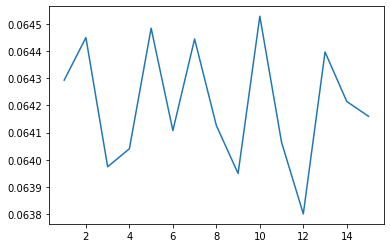

running loss =>  0.0642383470330187 loss_1 0.038682817651699945 loss_2 0.00991120462551444 loss_3 0.015644324327956975


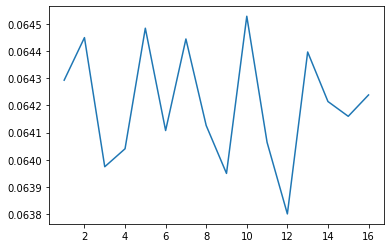

running loss =>  0.06431909137836067 loss_1 0.03877023867862199 loss_2 0.009915032247889548 loss_3 0.01563382016129032


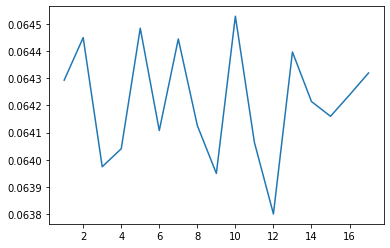

running loss =>  0.06422107306218916 loss_1 0.03868777018481044 loss_2 0.009903536327081503 loss_3 0.01562976643145161


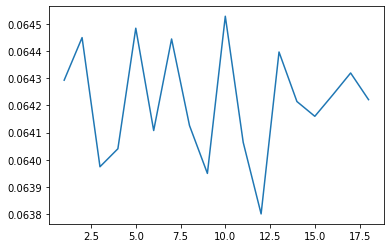

running loss =>  0.06386969026218178 loss_1 0.038348944557289925 loss_2 0.009896793676365164 loss_3 0.015623951646505376


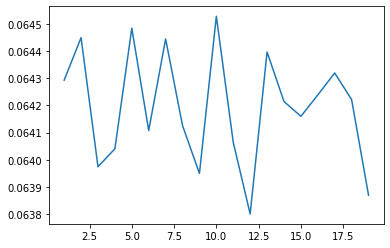

running loss =>  0.06419049956465281 loss_1 0.038642805730623585 loss_2 0.009907426911361766 loss_3 0.015640266565860216


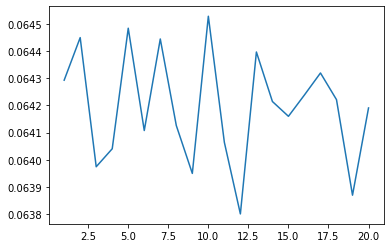

running loss =>  0.0640656766231342 loss_1 0.0385422972181151 loss_2 0.009894504584375755 loss_3 0.015628874378360216


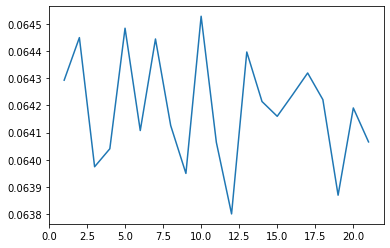

running loss =>  0.06424509725903951 loss_1 0.038723033121837086 loss_2 0.009893455826003632 loss_3 0.015628608467741934


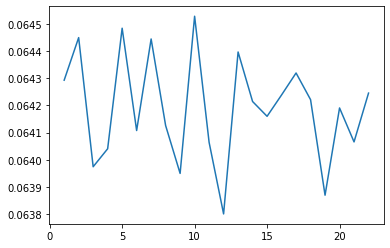

running loss =>  0.06422705151220803 loss_1 0.038713245642601805 loss_2 0.009899809117971227 loss_3 0.015613996404569896


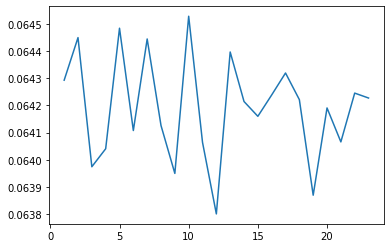

running loss =>  0.06390179765801277 loss_1 0.03838738949308472 loss_2 0.009904131953570306 loss_3 0.015610276075268822


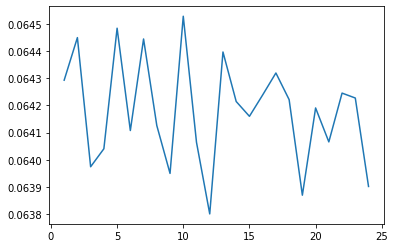

running loss =>  0.0640825982536039 loss_1 0.03856880189750784 loss_2 0.009901454504940888 loss_3 0.015612342069892473


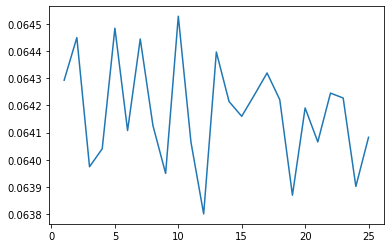

running loss =>  0.06361130388673916 loss_1 0.03808272794209501 loss_2 0.009907584829298856 loss_3 0.015620990540994618


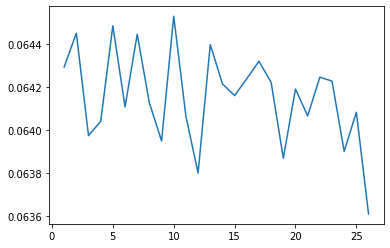

running loss =>  0.06371773370812016 loss_1 0.03819556712543452 loss_2 0.009907967630242709 loss_3 0.01561419848790323


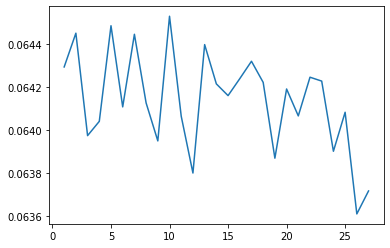

running loss =>  0.0642332652163121 loss_1 0.03869909548791506 loss_2 0.009915337384907382 loss_3 0.015618832241263446


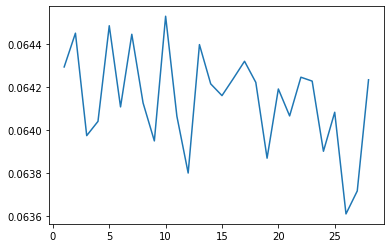

running loss =>  0.06400903943245129 loss_1 0.038507765880034815 loss_2 0.00989341276187226 loss_3 0.015607860450268816


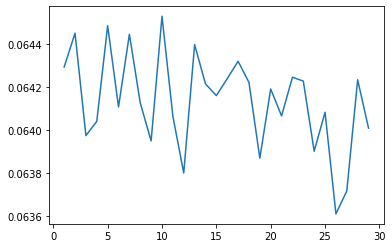

running loss =>  0.06418383257683888 loss_1 0.03867369401519016 loss_2 0.009901072034207311 loss_3 0.015609066767473116


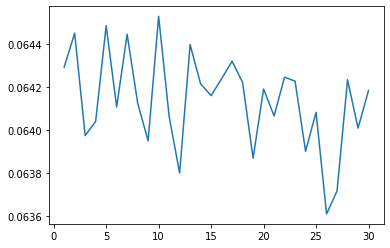

running loss =>  0.0639044239075594 loss_1 0.03840141891632029 loss_2 0.009898388559402494 loss_3 0.015604616330645164


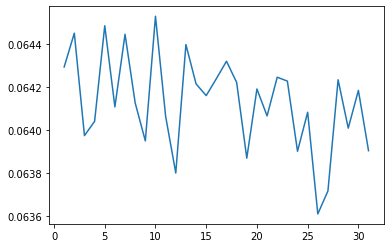

running loss =>  0.06396465652411984 loss_1 0.038466844066817274 loss_2 0.009890661535149765 loss_3 0.015607150974462365


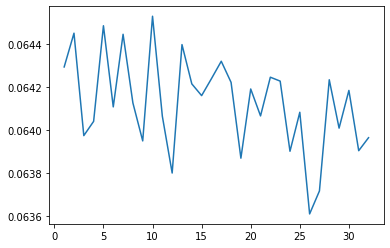

running loss =>  0.06420740653430262 loss_1 0.03869608339042433 loss_2 0.009917254496589659 loss_3 0.015594068548387094


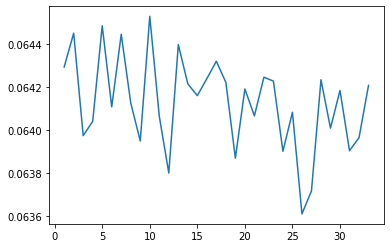

running loss =>  0.06365608464005174 loss_1 0.03814442511848224 loss_2 0.009909838813026125 loss_3 0.015601820799731186


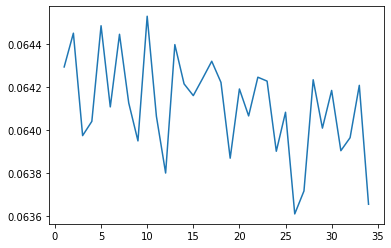

running loss =>  0.06403873015635757 loss_1 0.038532821401473016 loss_2 0.00991094490903464 loss_3 0.01559496345766129


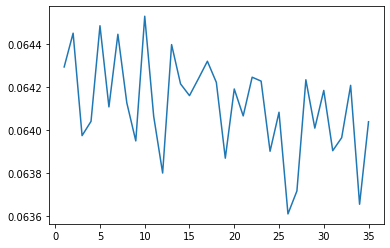

running loss =>  0.06437112787558187 loss_1 0.038864759528028064 loss_2 0.009897898075810752 loss_3 0.015608469993279573


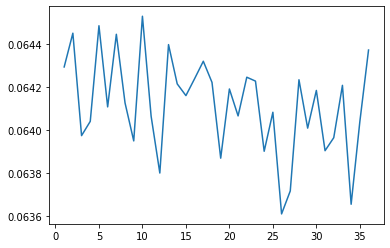

running loss =>  0.0638327745580545 loss_1 0.03832417914784083 loss_2 0.00991437716517449 loss_3 0.01559421819556451


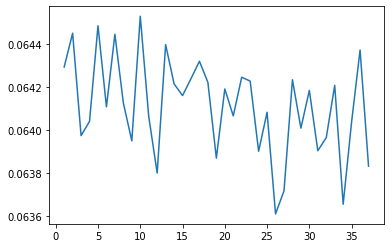

running loss =>  0.06385431610929068 loss_1 0.038337923205828156 loss_2 0.009911478951929977 loss_3 0.015604914045698918


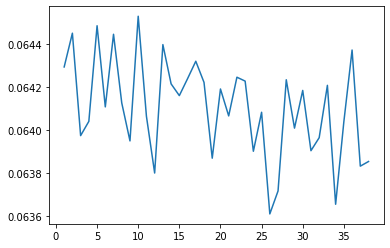

running loss =>  0.06377873717937418 loss_1 0.038293358639523545 loss_2 0.009891047668244146 loss_3 0.015594330712365594


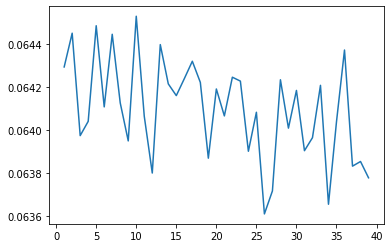

running loss =>  0.06416286676320979 loss_1 0.038671926665370185 loss_2 0.009905411790343911 loss_3 0.015585527906586025


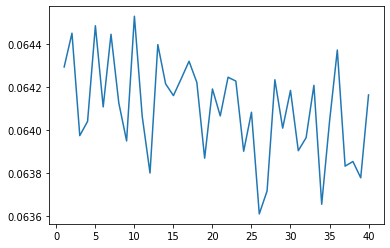

running loss =>  0.06394805410696615 loss_1 0.03845348866075598 loss_2 0.009911027696607438 loss_3 0.015583537768817202


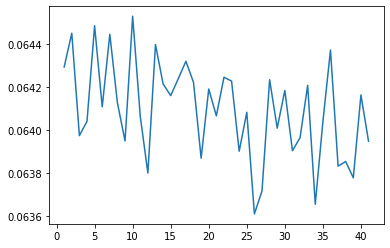

running loss =>  0.06391456815344031 loss_1 0.03844792804410381 loss_2 0.009900067130110685 loss_3 0.015566572899865587


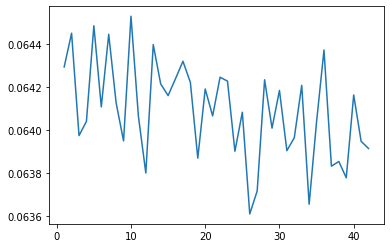

running loss =>  0.06428386723642708 loss_1 0.038793685555618296 loss_2 0.009907450361124304 loss_3 0.015582731283602151


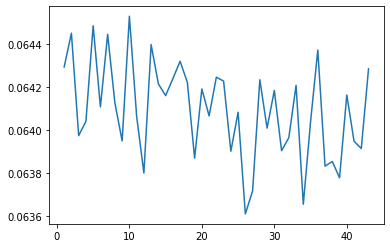

running loss =>  0.06423897864998028 loss_1 0.03874571939870235 loss_2 0.009904089568694065 loss_3 0.01558916917002688


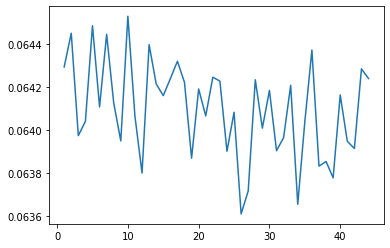

running loss =>  0.06383429199296942 loss_1 0.03834724818827004 loss_2 0.009910594312871 loss_3 0.015576449395161288


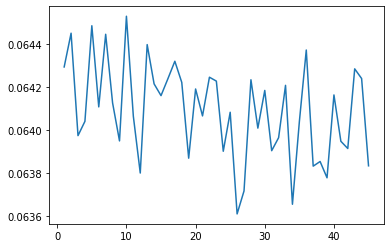

running loss =>  0.06388006271213613 loss_1 0.03839791772426457 loss_2 0.009894384818690436 loss_3 0.015587759946236554


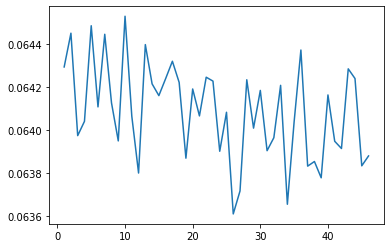

running loss =>  0.06406521420645457 loss_1 0.03857788287343517 loss_2 0.00991374908438612 loss_3 0.01557358200604838


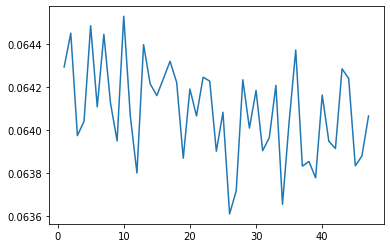

running loss =>  0.06390211578979287 loss_1 0.03841816329507418 loss_2 0.00990764689932315 loss_3 0.015576305645161291


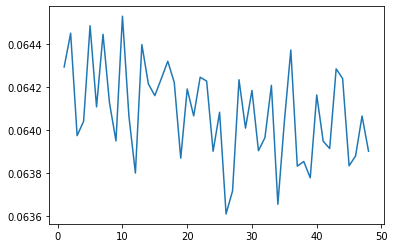

running loss =>  0.06363438474394942 loss_1 0.03815217686676851 loss_2 0.009900565911823957 loss_3 0.015581641633064514


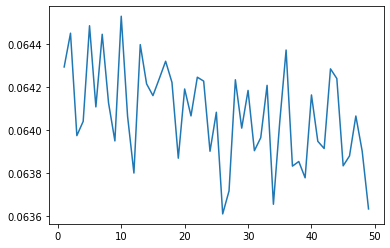

running loss =>  0.0638904845522296 loss_1 0.03843017987987046 loss_2 0.009890412174331604 loss_3 0.01556989250672043


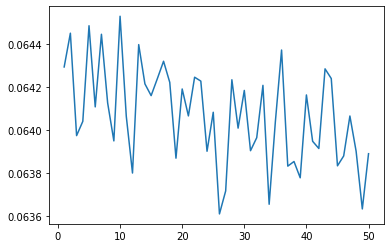

running loss =>  0.06419753675819725 loss_1 0.038719338935709766 loss_2 0.00991171219417644 loss_3 0.015566485601478488


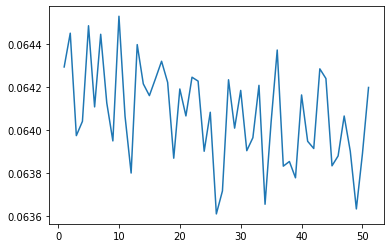

running loss =>  0.06416347450626794 loss_1 0.03866646839405901 loss_2 0.009923741176468761 loss_3 0.01557326490255376


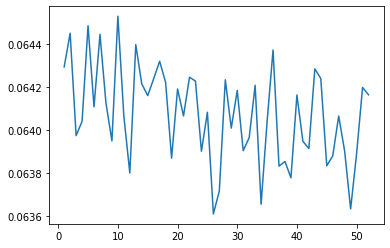

running loss =>  0.06397873820156179 loss_1 0.038504050904384225 loss_2 0.009900829173330995 loss_3 0.01557385782930108


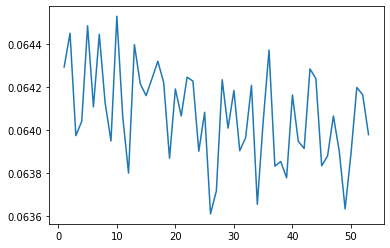

running loss =>  0.06394779790313013 loss_1 0.038473775009474444 loss_2 0.00990433890476061 loss_3 0.015569683988575268


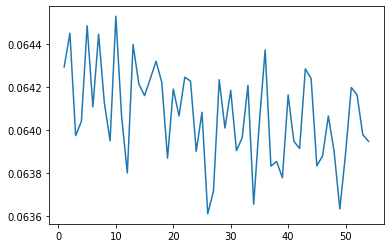

In [0]:
net = train(net, train_loader=train_loader, num_epoch=50, lr=0.0000001, with_graph=True, save_=True)